<a href="https://colab.research.google.com/github/Bilpapster/NNs-playground/blob/main/2.%20SVMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second assignment in Neural Networks - Deep Learning

### Implementing Support Vector Machines

> Vasileios Papastergios (ID: 3651)


---


# Introduction

The current Jupiter Notebook contains python source code for the second obligatory assignment in the course of [Neural Networks - Deep Learing](https://qa.auth.gr/en/x/class/1/600237255). The author attended the course during their 7th semester of studies at the [Aristotle University of Thessaloniki (AUTH)](https://www.csd.auth.gr/en/).

The current assignment focuses on implementing multiple Support Vector Machines in order to solve the multiclass image classification task we have selected through this assignment series. We have selected to work with the [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data) dataset, which was found on [Kaggle](https://www.kaggle.com/datasets). The dataset consists of a train set (14K images) and a test set (3K images) of images that belong to one of the 6 (mutually exclusive) following classes:
1. buildings
2. forest
3. glacier
4. mountain
5. sea
6. street

We try multiple approaches, by training several SVMs with different kernels and hyperparameters.

First of all, we mount the Google Drive storage of our account, because that is where we store the dataset files.

In [3]:
from google.colab import drive
drive.mount('/gdrive')

import numpy as np

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


At first, we load train data, stored in our Google Drive. Each image has dimensions 150 x 150 x 3 (RGB). There are 14'034 train images in total, thus the train data is 14'034 x 150 x 150 x 3.

In [2]:
import numpy as np
from sklearn.utils import shuffle

with open('/gdrive/My Drive/Kaggle/Dataset/train.npy', 'rb') as f:
  X_train = np.load(f).astype("float32")
  X_train /= 255.

with open('/gdrive/My Drive/Kaggle/Dataset/train labels.npy', 'rb') as f:
  y_train = np.load(f)
  y_train = y_train

print(f'Shape of X_train: {np.shape(X_train)}')
print(f'Shape of y_train: {np.shape(y_train)}')

Shape of X_train: (14034, 150, 150, 3)
Shape of y_train: (14034,)


We, then, visualize a random for data exploration purposes.

Text(0.5, 1.0, 'sea (index 11590)')

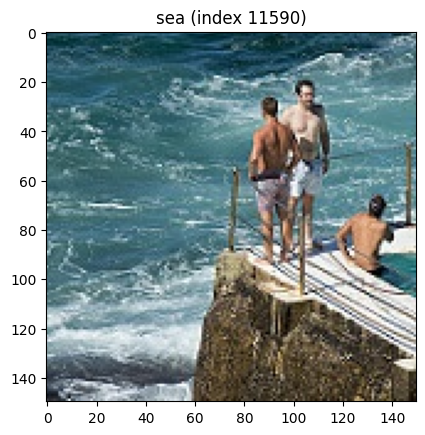

In [6]:
import matplotlib.pyplot as plt

import random
labels_list = [
    "buildings",
    "forest",
    "glacier",
    "mountain",
    "sea",
    "street"
]

random_index = random.randint(0, len(X_train)-1)
random_image = (X_train[random_index]*255).astype(int)
plt.imshow(random_image)
plt.title(f"{labels_list[(y_train[random_index]).astype(int)]} (index {random_index})")

## Approach 1: Training an autoencoder for dimensionality reduction

This is our first attempt to reduce the dimensionality of the train set (14'034 x 150 x 150 x 3). For that purpose, we will try to train an autoencoder, and then use the (trained) encoder part, in order to reduce the dimensionality. In simple words, after end-to-end training of the autoencoder, we keep only the encoding part. We use the encoder's output, as the input to the SVM(s).

Due to limited resources (Google Colab Free edition), we perform batch training: we train the autoencoder with 5000 examples for 100 epochs. Right after, we load another 5000 examples and continue training. Lastly, we load the last 4034 training examples for another 100 epochs. We use the autoencoder produced at the end of the latter step.

We aknowledge that the training process is not ideal. The ideal situation would have been training with the total train data (14'034 x 150 x 150 x 3) at once. However, our (forced, due to restricted resources) approach approximates the result that would have emerged through the ideal training process.

In [ ]:
# Building an autoencoder to get an intermediate representation!
from keras.layers import Input, Dense, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import keras
from keras import layers
from keras.utils import to_categorical
import random

batch_size = 64
epochs = 100
hidden_representation_shape = (5, 5, 8)
hidden_representation_shape_flattened = 5*5*8

# Defining a symmetric, convolutional autoencoder

# ---------------------------------- ENCODER ----------------------------------
ae_input = Input(shape=(150, 150, 3))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(ae_input)
x = layers.MaxPooling2D((3, 3), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x) # hidden representation is 5*5*8
x = layers.MaxPooling2D((5, 5), padding='same')(x)
encoded = layers.Flatten()(x)                                      # when flattened, it is 200 numbers for each image!

# ---------------------------------- DECODER ----------------------------------
x = layers.Reshape(hidden_representation_shape)(encoded)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((5, 5))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((3, 3))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

encoder = Model(ae_input, encoded)
decoder = Model(encoded, decoded)
autoencoder = Model(ae_input, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(autoencoder.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 8)         584 

In [ ]:
# fitting the autoencoder for 100 epochs with the first part of the train data

history = autoencoder.fit(
  X_train,
  X_train,
  batch_size=batch_size,
  epochs=epochs,
  verbose='auto',
)

Epoch 1/100
79/79 [==============================] - 184s 2s/step - loss: 0.6449 - accuracy: 0.3495
Epoch 2/100
79/79 [==============================] - 175s 2s/step - loss: 0.5905 - accuracy: 0.4306
Epoch 3/100
79/79 [==============================] - 177s 2s/step - loss: 0.5837 - accuracy: 0.4387
Epoch 4/100
79/79 [==============================] - 177s 2s/step - loss: 0.5793 - accuracy: 0.4896
Epoch 5/100
79/79 [==============================] - 175s 2s/step - loss: 0.5757 - accuracy: 0.5080
Epoch 6/100
79/79 [==============================] - 178s 2s/step - loss: 0.5736 - accuracy: 0.5121
Epoch 7/100
79/79 [==============================] - 183s 2s/step - loss: 0.5729 - accuracy: 0.5245
Epoch 8/100
79/79 [==============================] - 180s 2s/step - loss: 0.5721 - accuracy: 0.5371
Epoch 9/100
79/79 [==============================] - 180s 2s/step - loss: 0.5715 - accuracy: 0.5441
Epoch 10/100
79/79 [==============================] - 177s 2s/step - loss: 0.5711 - accuracy: 0.5485

FileNotFoundError: ignored

Saving the autoencoder history to disk for later use.

In [ ]:
import pickle

autoencoder.save('/gdrive/My Drive/Kaggle/autoencoder.keras')
print('Starting writing history to file...')
writefile = open('/gdrive/My Drive/Kaggle/autoencoder_history.pkl', "wb")
pickle.dump(history, writefile)
writefile.close()
print('Finished writing history to file ...')

Starting writing history to file...
Finished writing history to file ...


Continuing training with the second (out of three) part of the train data. Loading the train data:

In [ ]:
# load another part of the train data and continue training of the autoencoder for another 100 epochs

import numpy as np

start_index = 5000
end_index = 10000

with open('/gdrive/My Drive/Kaggle/Dataset/train.npy', 'rb') as f:
  X_train = np.load(f)
  X_train = (X_train[start_index:end_index]/255.).astype("float")

with open('/gdrive/My Drive/Kaggle/Dataset/train labels.npy', 'rb') as f:
  y_train = np.load(f)
  y_train = y_train[start_index:end_index]

print(f'Shape of X_train: {np.shape(X_train)}')
print(f'Shape of y_train: {np.shape(y_train)}')

Shape of X_train: (5000, 150, 150, 3)
Shape of y_train: (5000,)


Training the autoencoder, starting from the weights that emerged from the first fit:

In [ ]:
import keras

autoencoder = keras.models.load_model('/gdrive/My Drive/Kaggle/autoencoder.keras')
batch_size = 64
epochs = 100

history = autoencoder.fit(
  X_train,
  X_train,
  batch_size=batch_size,
  epochs=epochs,
  verbose='auto',
)

import pickle

autoencoder.save('/gdrive/My Drive/Kaggle/autoencoder2.keras')
print('Starting writing history to file...')
writefile = open('/gdrive/My Drive/Kaggle/autoencoder2_history.pkl', "wb")
pickle.dump(history, writefile)
writefile.close()
print('Finished writing history to file ...')

Epoch 1/100
79/79 [==============================] - 175s 2s/step - loss: 0.5638 - accuracy: 0.7830
Epoch 2/100
79/79 [==============================] - 170s 2s/step - loss: 0.5635 - accuracy: 0.7840
Epoch 3/100
79/79 [==============================] - 176s 2s/step - loss: 0.5632 - accuracy: 0.7837
Epoch 4/100
79/79 [==============================] - 170s 2s/step - loss: 0.5632 - accuracy: 0.7848
Epoch 5/100
79/79 [==============================] - 174s 2s/step - loss: 0.5632 - accuracy: 0.7850
Epoch 6/100
79/79 [==============================] - 170s 2s/step - loss: 0.5630 - accuracy: 0.7860
Epoch 7/100
79/79 [==============================] - 178s 2s/step - loss: 0.5631 - accuracy: 0.7856
Epoch 8/100
79/79 [==============================] - 170s 2s/step - loss: 0.5629 - accuracy: 0.7861
Epoch 9/100
79/79 [==============================] - 174s 2s/step - loss: 0.5630 - accuracy: 0.7851
Epoch 10/100
79/79 [==============================] - 170s 2s/step - loss: 0.5628 - accuracy: 0.7859

Finally, repeating the same process for the last (3rd) part of the training data. We keep training the autoencoder, starting with the weights as they were formed from the previous step. Loading the train data and fitting the autoencoder:

In [ ]:
del X_train
del y_train
import numpy as np

start_index = 10000
# end_index = None

with open('/gdrive/My Drive/Kaggle/Dataset/train.npy', 'rb') as f:
  X_train = np.load(f)
  X_train = (X_train[start_index:]/255.).astype("float")

print(f'Shape of X_train: {np.shape(X_train)}')

import keras

autoencoder = keras.models.load_model('/gdrive/My Drive/Kaggle/autoencoder2.keras')
batch_size = 64
epochs = 100

history = autoencoder.fit(
  X_train,
  X_train,
  batch_size=batch_size,
  epochs=epochs,
  verbose='auto',
)

import pickle

autoencoder.save('/gdrive/My Drive/Kaggle/autoencoder3.keras')
print('Starting writing history to file...')
writefile = open('/gdrive/My Drive/Kaggle/autoencoder3_history.pkl', "wb")
pickle.dump(history, writefile)
writefile.close()
print('Finished writing history to file ...')

Shape of X_train: (4034, 150, 150, 3)
Epoch 1/100
64/64 [==============================] - 141s 2s/step - loss: 0.5683 - accuracy: 0.6894
Epoch 2/100
64/64 [==============================] - 134s 2s/step - loss: 0.5680 - accuracy: 0.6901
Epoch 3/100
64/64 [==============================] - 136s 2s/step - loss: 0.5680 - accuracy: 0.6909
Epoch 4/100
64/64 [==============================] - 135s 2s/step - loss: 0.5680 - accuracy: 0.6890
Epoch 5/100
64/64 [==============================] - 141s 2s/step - loss: 0.5678 - accuracy: 0.6934
Epoch 6/100
64/64 [==============================] - 135s 2s/step - loss: 0.5677 - accuracy: 0.6917
Epoch 7/100
64/64 [==============================] - 135s 2s/step - loss: 0.5677 - accuracy: 0.6943
Epoch 8/100
64/64 [==============================] - 135s 2s/step - loss: 0.5676 - accuracy: 0.6925
Epoch 9/100
64/64 [==============================] - 141s 2s/step - loss: 0.5676 - accuracy: 0.6938
Epoch 10/100
64/64 [==============================] - 134s 2s/

It's now time to evaluate our autoencoder! At first, we load the test data:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import keras

autoencoder = keras.models.load_model('/gdrive/My Drive/Kaggle/autoencoder3.keras')

with open('/gdrive/My Drive/Kaggle/Dataset/test.npy', 'rb') as f:
  X_test = np.load(f)
  X_test = (X_test/255.).astype("float")

print(f'Shape of X_test : {np.shape(X_test)}')

Shape of X_test : (3000, 150, 150, 3)


Then, we evaluate our autoencoder. As we can see, it reaches a test accuracy of 70.95%:

In [ ]:
results = autoencoder.evaluate(X_test, X_test, batch_size=128)
print("test loss, test acc:", results)

24/24 [==============================] - 34s 1s/step - loss: 0.5632 - accuracy: 0.7095
test loss, test acc: [0.5631741881370544, 0.7095350623130798]


One really interesting note we would like to make is visualizing the autoencoder results. That means we (vertically) compare the original with the reconstructed image for a random sample of the test images. Based on the below visualizations, we observe that the reconstructed image has kept the main content of the original one, but in a blurry way! We can now better understand the 70.95% test accuracy of the autoencoder.

94/94 [==============================] - 31s 330ms/step


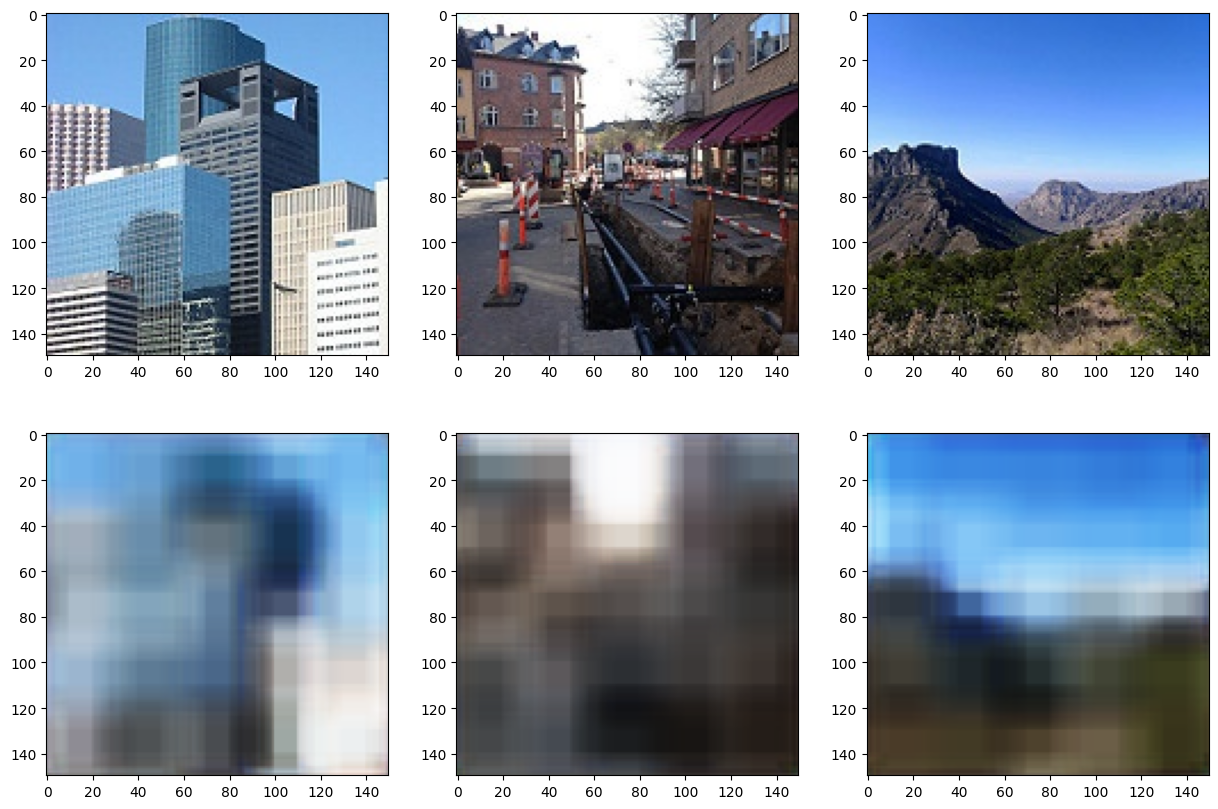

In [ ]:
import random
import matplotlib.pyplot as plt

predictions = autoencoder.predict(X_test)
random_index1 = random.randint(0, 3000)
random_index2 = random.randint(0, 3000)
random_index3 = random.randint(0, 3000)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
original_images = (X_test*255).astype("int")
predictions_int = (predictions*255).astype("int")

ax1.imshow(original_images[random_index1])
ax2.imshow(original_images[random_index2])
ax3.imshow(original_images[random_index3])
ax4.imshow(predictions_int[random_index1])
ax5.imshow(predictions_int[random_index2])
ax6.imshow(predictions_int[random_index3])


It is now time to use the autoencoder for the actual, SVM implementation task. As a matter of fact, we only use the encoder part of the trained autoencoder. For that reason, we load the trained autoencoder from disk and keep only the first 7 layers, which constitute the encoder part:

In [ ]:
import tensorflow as tf
import numpy as np

autoencoder = tf.keras.models.load_model('/gdrive/My Drive/Kaggle/autoencoder.keras')

# Create a Sequential Model and transfer the encoder layers one by one
encoder = tf.keras.Sequential()
for layer in autoencoder.layers[:8]:
  encoder.add(layer)

print(encoder.summary())
del autoencoder

with open('/gdrive/My Drive/Kaggle/Dataset/train.npy', 'rb') as f:
  X_train = np.load(f)

with open('/gdrive/My Drive/Kaggle/Dataset/test.npy', 'rb') as f:
  X_test = np.load(f)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 8)         584       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 8)           0

We now use the encoder to transform the original `X_train` data from (14'034 x 150 x 150 x 3) to (14'034 x 200). Due to RAM limitations, we do the process in batches of 1000 training examples at a time. When finished, we write the `X_train_transformed` (14'034 x 200) to disk, so that we can use it easily from now on, without the need to recompute it.

In [ ]:
X_train_transformed = np.array([])
index = 0
step = 1000
more_train_examples = True
while more_train_examples:
  end_index = index + step
  if end_index > len(X_train):
    end_index = len(X_train)
    more_train_examples = False
  examples_batch = X_train[index:end_index]
  examples_batch = (examples_batch/255.).astype("float")
  predictions_batch = encoder.predict(examples_batch)
  X_train_transformed = predictions_batch if index == 0 else np.append(X_train_transformed, predictions_batch, axis=0)
  index = index + step

print(X_train_transformed.shape)
np.save('/gdrive/My Drive/Kaggle/X_train_transformed.npy', X_train_transformed)

2/2 [==============================] - 0s 21ms/step
(14034, 200)


We do the exact same process for `X_test` and persist to disk the produced `X_test_transformed` vector with dimensions 3'000 test examples x 200.

In [ ]:
X_test_transformed = np.array([])
index = 0
step = 1001
more_test_examples = True
while more_test_examples:
  end_index = index + step
  if end_index > len(X_test):
    end_index = len(X_test)
    more_test_examples = False
  examples_batch = X_test[index:end_index]
  examples_batch = (examples_batch/255.).astype("float")
  predictions_batch = encoder.predict(examples_batch)
  X_test_transformed = predictions_batch if index == 0 else np.append(X_test_transformed, predictions_batch, axis=0)
  index = index + step

print(X_test_transformed.shape)
np.save('/gdrive/My Drive/Kaggle/X_test_transformed.npy', X_test_transformed)

32/32 [==============================] - 2s 70ms/step
(3000, 200)


Having done all these steps, we now have an appropriate input representation for the SVM flavors we want to try. We load the transformed train and test data:

In [11]:
import numpy as np
from sklearn.utils import shuffle

nof_samples = 14034


with open('/gdrive/My Drive/Kaggle/X_train_transformed.npy', 'rb') as f:
  X_train = np.load(f)

with open('/gdrive/My Drive/Kaggle/Dataset/train labels.npy', 'rb') as f:
  y_train = np.load(f)

X_train, y_train = shuffle(X_train, y_train, random_state=7)
# X_train = X_train[:nof_samples]
# y_train = y_train[:nof_samples]

print(f"Shape of X_train{X_train.shape}")
print(f"Shape of y_train{y_train.shape}")

with open('/gdrive/My Drive/Kaggle/X_test_transformed.npy', 'rb') as f:
  X_test = np.load(f)

with open('/gdrive/My Drive/Kaggle/Dataset/test labels.npy', 'rb') as f:
  y_test = np.load(f)


print(f"Shape of X_test{X_test.shape}")
print(f"Shape of y_test{y_test.shape}")

Shape of X_train(14034, 200)
Shape of y_train(14034,)
Shape of X_test(3000, 200)
Shape of y_test(3000,)


## A few utility functions before starting

In [8]:
%pip install sklearn_evaluation

from sklearn_evaluation import plot

def plot_grid_heatmap(grid_results, change=("C", "gamma"), cmap="Blues_r"):
  plot.grid_search(grid_results, change=change, cmap=cmap)

In [9]:
from timeit import default_timer as timer

def fit_evaluate_SVM(svm_classifier, X_train, y_train, X_test, y_test):
  start_time = timer()
  svm_classifier.fit(X_train, y_train)
  duration = timer() - start_time

  print(f"Accuracy score on train set        : {svm_classifier.score(X_train, y_train) * 100} %.")
  print(f"Accuracy score on test set         : {svm_classifier.score(X_test, y_test) * 100} %.")
  print(f"Time elapsed during fitting        : {duration} sec")
  print(f"Number of support vectors per class: {svm_classifier.n_support_}")


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_classification_examples(classifier, X_test, y_test):
  """
  A utility function that plots correct and wrong classification examples
  in a 2x3 rows
  """

  labels_list = [
      "buildings",
      "forest",
      "glacier",
      "mountain",
      "sea",
      "street"
  ]

  with open('/gdrive/My Drive/Kaggle/Dataset/test.npy', 'rb') as f:
    original_images = np.load(f).astype("int")

  y_pred = classifier.predict(X_test)
  nof_predictions = len(y_pred)
  nof_examples = 6


  # original_images = X_test_original.astype("int")
  prediction_flags = y_test == y_pred

  correct_examples = []
  wrong_examples = []

  for index, prediction_flag in enumerate(prediction_flags):
    if prediction_flag:
      correct_examples.append(index)
    else:
      wrong_examples.append(index)

  if len(correct_examples) > nof_examples / 2:
    correct_examples = np.random.choice(correct_examples, size=int(nof_examples/2), replace=False)

  if len(wrong_examples) > nof_examples / 2:
    wrong_examples = np.random.choice(wrong_examples, size=int(nof_examples/2), replace=False)

  fig, (ax_correct, ax_wrong) = plt.subplots(2, 3, figsize=(20, 15))

  for index, correct_example in enumerate(correct_examples):
    ax_correct[index].imshow(original_images[correct_example])
    ax_correct[index].set_title(f"Correctly classified as {labels_list[y_pred[correct_example]]}")

  for index, wrong_example in enumerate(wrong_examples):
    ax_wrong[index].imshow(original_images[wrong_example])
    ax_wrong[index].set_title(f"Misclassified as {labels_list[y_pred[wrong_example]]} (actually {labels_list[y_test[wrong_example]]})")

## RBF Kernel grid search

The first SVM flavor we opt for implementing is an RBF-Kernel one. We perform a grid search for both $C$ and $γ$. We check all possible combinations (cartesian product) for

$C = 2^{-3}, 2^{-1}, …, 2^7, 2^9$

and

$γ = 2^{-10}, 2^{-8}, …, 2, 4$

We print the grid search results, as shown in the terminal output below.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel':['rbf'],
              'C': [2 ** x for x in range(-3, 10, 2)],
              'gamma': [2 ** x for x in range(-10, 3, 2)]
              }

grid = GridSearchCV(SVC(), n_jobs=-1, verbose=3, param_grid=param_grid, cv=2)
grid.fit(X_train, y_train)
print(f"Best parameters found by grid search: {grid.best_params_}")

Fitting 2 folds for each of 49 candidates, totalling 98 fits
Best parameters found by grid search: {'C': 2, 'gamma': 0.25, 'kernel': 'rbf'}


At this point we know the combination with the best mean accuracy score during 2-fold cross validation among all tested combinations. The best hyperparameters found are the following:

$C = 2$

$\gamma = 0.25$

We now use these hyperparameters to train an RBF-kernel SVM with **all** the train data. We evaluate its performance on the train and test data. We also print the number of support vectors computed for each one for the six classes of the classification problem we are trying to solve.

In [12]:
clf = SVC(gamma=grid.best_params_['gamma'], C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
fit_evaluate_SVM(clf, X_train, y_train, X_test, y_test)

Accuracy score on train set        : 88.57061422260225 %.
Accuracy score on test set         : 70.06666666666666 %.
Time elapsed during fitting        : 25.802220143999875 sec
Number of support vectors per class: [1914  867 1783 1881 2045 1621]


As we can see, our first SVM flavor reaches a test accuracy of 70.06%, which is close to the test accuracy of the autoencoder itself (70.96%).

For better understanding of the grid search cross validation results, we can create a grid heatmaps, as shown below.

<Axes: >

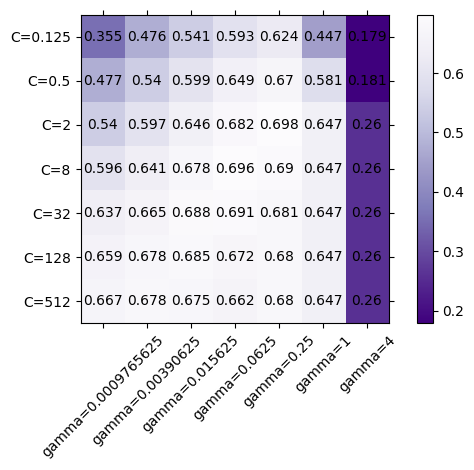

In [ ]:
plot_grid_heatmap(grid.cv_results_, change=("gamma", "C"), cmap='Purples_r')

The grid cross validation results heatmap can be really helpful for us to define our next steps. We observe that the best mean accuracies are placed in the middle part of the heatmap. We choose to perform one more, nested (refined) grid search for more thorough investigation of the hyperparameter search space, in the area of interest. In our refined grid search, we check all combinations between

$C ∈ [1, 8)$

and

$γ = 2^{-11}, 2^{-9}, …, 2$

In [14]:
# Refining our grid search

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel':['rbf'],
              'C': [x for x in range(1, 8)],
              'gamma': [2 ** x for x in range(-11, 3, 2)]
              }

grid = GridSearchCV(SVC(), n_jobs=-1, verbose=3, param_grid=param_grid, cv=2)
grid.fit(X_train, y_train)

print(f"Best parameters found by grid search: {grid.best_params_}")

clf = SVC(gamma=grid.best_params_['gamma'], C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
fit_evaluate_SVM(clf, X_train, y_train, X_test, y_test)

Best parameters found by grid search: {'C': 5, 'gamma': 0.125, 'kernel': 'rbf'}
Accuracy score on train set        : 86.88898389625196 %.
Accuracy score on test set         : 70.56666666666666 %.
Time elapsed during fitting        : 41.46472319100212 sec
Number of support vectors per class: [1778  769 1721 1779 1948 1459]


We observe that the train accuracy drops but the test accuracy **slightly increases** (from 70.06 to 70.56). Thus, our refined (nested) grid search shows that, with the given representation, we probably cannot achieve a much better performance. The following heatmap shows guides our thought towards the same direction.

<Axes: >

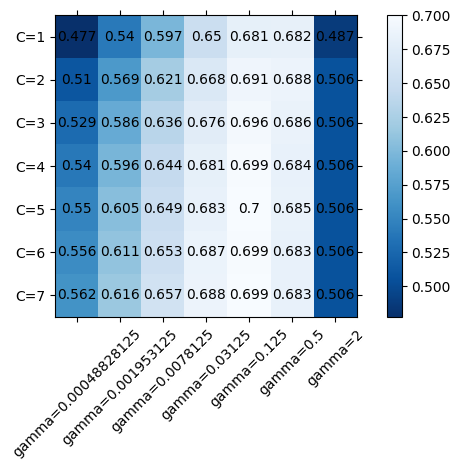

In [ ]:
plot_grid_heatmap(grid.cv_results_, change=("gamma", "C"), cmap='Blues_r')

## Approach 2 (Experimental) Trying a non-trained, randomly initialized MLP for dimensionality reduction

Having implemented an autoencoder for dimensionality reduction, we now change our way of thinking towards an intuition. Our idea is to investigate the performance of an RBF-kerned SVM flavor, where the input is the output of a ***non-trained, randomly initialized MLP***!

The reasoning behind such an investigation is the fact that transforming all (150 x 150 x 3) images to (1, 200) vectors with a random, but **same for every image**, non-linear trasnformation could give a good representation of the initial data.

HINT: The concept was intriguing, however it did not work as expected.

At first, we initailize a `Sequential`, fully connected keras model (MLP) with 2 hidden layers (700 and 300 neurons respectively). Both the weights and the biases of the whole MLP are initialized to be random numbers sampled from a normal distribution ($μ = 0$, $σ=1$). The output of the model is a (1, 200) vector, the same dimension we used before.

We, then, perform a grid search for the hyperparametes $C$ and $γ$ of an RBF-kernel SVM. The final test accuracy of the model does not meet our investigation goals. We achieve a 55.60% test accuracy, even when performing a refined grid search in a more specific area of the hyperparameter space.

This approach is evaluated as worse than the first we attempted (encoder and then RBF-kernel SVM), since for the same compression (200 numbers per image) the test accuracy is much worse (50.60% vs 70.56%).



In [ ]:
import keras
import numpy as np
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Defining a MLP and initializing its weights as random_normal numbers
input = keras.layers.Input(shape=(150, 150, 3))
x = keras.layers.Flatten()(input)
x = keras.layers.Dense(units=700, kernel_initializer='random_normal', bias_initializer='random_normal', activation="relu")(x)
x = keras.layers.Dense(units=300, kernel_initializer='random_normal', bias_initializer='random_normal', activation="relu")(x)
output = keras.layers.Dense(units=200, kernel_initializer='random_normal', bias_initializer='random_normal', activation="relu")(x)

random_MLP = keras.Model(input, output)
random_MLP.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-3), loss='categorical_crossentropy', metrics=['accuracy'])
print(random_MLP.summary())


# Loading the untact (150 x 150 x 3) train and test data
with open('/gdrive/My Drive/Kaggle/Dataset/train.npy', 'rb') as f:
  X_train = np.load(f).astype("float32")

with open('/gdrive/My Drive/Kaggle/Dataset/train labels.npy', 'rb') as f:
  y_train = np.load(f).astype("float32")

with open('/gdrive/My Drive/Kaggle/Dataset/test.npy', 'rb') as f:
  X_test = np.load(f).astype("float32")

with open('/gdrive/My Drive/Kaggle/Dataset/test labels.npy', 'rb') as f:
  y_test = np.load(f).astype("float32")


# Transforming the train data
X_train_transformed = np.array([])
index = 0
step = 1000
more_train_examples = True
while more_train_examples:
  end_index = index + step
  if end_index > len(X_train):
    end_index = len(X_train)
    more_train_examples = False
  examples_batch = X_train[index:end_index]
  examples_batch /= 255.
  predictions_batch = random_MLP.predict(examples_batch)
  X_train_transformed = predictions_batch if index == 0 else np.append(X_train_transformed, predictions_batch, axis=0)
  index = index + step

# Saving the transformed train data to disk
np.save('/gdrive/My Drive/Kaggle/X_train_transformed_random.npy', X_train_transformed)


# Transforming the test data
X_test_transformed = np.array([])
index = 0
step = 1001
more_test_examples = True
while more_test_examples:
  end_index = index + step
  if end_index > len(X_test):
    end_index = len(X_test)
    more_test_examples = False
  examples_batch = X_test[index:end_index]
  examples_batch /= 255.
  predictions_batch = random_MLP.predict(examples_batch)
  X_test_transformed = predictions_batch if index == 0 else np.append(X_test_transformed, predictions_batch, axis=0)
  index = index + step

# Saving the transformed test data to disk
np.save('/gdrive/My Drive/Kaggle/X_test_transformed_random.npy', X_test_transformed)

print(f"Shape of X_train_transformed {X_train_transformed.shape}")
print(f"Shape of X_test_transformed {X_test_transformed.shape}")


# Performing grid search
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel':['rbf'],
              'C': [2 ** x for x in range(-3, 11, 2)],
              'gamma': [2 ** x for x in range(-11, 3, 2)]
              }

grid = GridSearchCV(SVC(), n_jobs=-1, verbose=3, param_grid=param_grid, cv=2)
grid.fit(X_train_transformed, y_train)
print(grid.best_params_)
clf = SVC(gamma=grid.best_params_['gamma'], C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
fit_evaluate_SVM(clf, X_train, y_train, X_test, y_test)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 700)               47250700  
                                                                 
 dense_1 (Dense)             (None, 300)               210300    
                                                                 
 dense_2 (Dense)             (None, 200)               60200     
                                                                 
Total params: 47521200 (181.28 MB)
Trainable params: 47521200 (181.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
32/32 [=====

In [15]:
# Refined grid search for more thorough investigation

import numpy as np

with open('/gdrive/My Drive/Kaggle/X_train_transformed_random.npy', 'rb') as f:
  X_train_transformed = np.load(f).astype("float32")

with open('/gdrive/My Drive/Kaggle/Dataset/train labels.npy', 'rb') as f:
  y_train = np.load(f).astype("float32")

with open('/gdrive/My Drive/Kaggle/X_test_transformed_random.npy', 'rb') as f:
  X_test_transformed = np.load(f).astype("float32")

with open('/gdrive/My Drive/Kaggle/Dataset/test labels.npy', 'rb') as f:
  y_test = np.load(f).astype("float32")

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel':['rbf'],
              'C': [2 ** x for x in range(-3, 11, 2)],
              'gamma': [2 ** x for x in range(-11, 3, 2)]
              }

grid = GridSearchCV(SVC(), n_jobs=-1, verbose=3, param_grid=param_grid, cv=2)
grid.fit(X_train_transformed, y_train)
print(grid.best_params_)
clf = SVC(gamma=grid.best_params_['gamma'], C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
fit_evaluate_SVM(clf, X_train, y_train, X_test, y_test)

Fitting 2 folds for each of 49 candidates, totalling 98 fits
Best hyperparameters found: {'C': 2, 'gamma': 0.0078125, 'kernel': 'rbf'}
Accuracy score on train set        : 65.5835827276614 %.
Accuracy score on test set         : 63.33333333333333 %.
Time elapsed during fitting        : 34.21527147600136 sec
Number of support vectors per class: [2026  997 1889 1882 2248 1713]


Deploy AI and data apps for free on Ploomber Cloud! Learn more: https://docs.cloud.ploomber.io/en/latest/quickstart/signup.html


<Axes: >

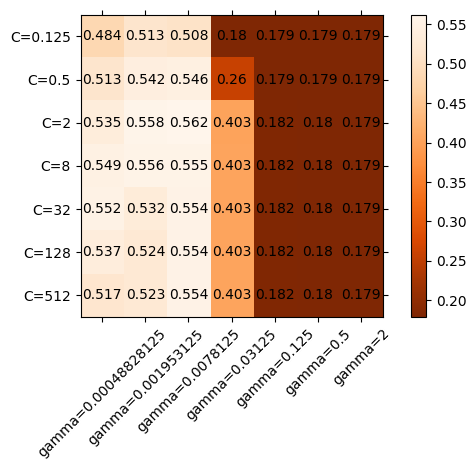

In [ ]:
plot_grid_heatmap(grid.cv_results_, change=("gamma", "C"), cmap='Oranges_r')

## Approach 3: Trying PCA for dimensionality reduction

In this third approach, we opt for reducing the dimensionality of the input data using **PCA**, with utter goal to train another SVM flavor. While implementing this approach, we enoucntered problems due to RAM limitations. In particular, we were not able to load more than the half (7'000 out of 14'037) training examples to perform PCA on the whole train matrix (14'034 x 67'500).

One solution to that problem would be to use a Hebbian NN that performs batch PCA, and, thus, manage to obtain the final representation without the need to have all 14'034 training examples in memory at the same time. We keep that solution in mind, in order to implement it in the third assignment series.

The workaround we used in order to overcome the encountered problem was to use only as many training examples as our RAM could handle simultaneously (7'000 training examples). We ensure that the 7'000 sampled training examples are distributed among all 6 classes of the classification task.

The result of the Principal Component Analysis is to transform the train data from (14'034 x 67'500) to (14'034 x 1'348). We use this data as the input to our next SVM flavor. We adopt the same approach again, with a general grid search at start, followed by a refined one, based on the findings of the first.



In [ ]:
np.shape(X_train) # original flattened train data size

(14034, 67500)

In [16]:
from sklearn.decomposition import PCA

# Make an instance of the Model
pca = PCA(.90)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test  = pca.transform(X_test)

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel':['rbf'],
              'C': [2 ** x for x in range(-3, 11, 2)],
              'gamma': [2 ** x for x in range(-11, 3, 2)]
              }

grid = GridSearchCV(SVC(), n_jobs=-1, verbose=3, param_grid=param_grid, cv=2)
grid.fit(X_train, y_train)
print(grid.best_params_)
clf = SVC(gamma=grid.best_params_['gamma'], C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
fit_evaluate_SVM(clf, X_train, y_train, X_test, y_test)

Fitting 2 folds for each of 49 candidates, totalling 98 fits
Best hyperparameters found: {'C': 2, 'gamma': 0.00048828125, 'kernel': 'rbf'}
Accuracy score on train set        : 54.36083796494229 %.
Accuracy score on test set         : 53.766666666666666 %.
Time elapsed during fitting        : 58.50282231700112 sec
Number of support vectors per class: [2190 1473 2140 2167 2274 2226]


Despite the fact that the train data seem to be clearly separatable (97.89% train accuracy), our SVM seems to overfit to the train data, since if fails (62.60 % accuracy) on the test data. The following heatmap shows the results of the initial, general grid search.

<Axes: >

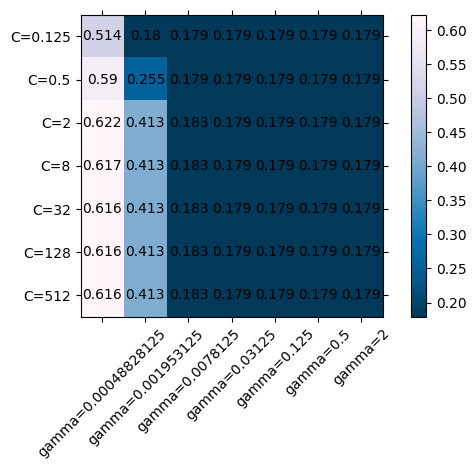

In [ ]:
plot_grid_heatmap(grid.cv_results_, change=("gamma", "C"), cmap='PuBu_r')

In [ ]:
print(f"Dimension of the train set after PCA: {np.shape(X_train)}")
print(f"Dimension of the test set after PCA : {np.shape(X_test)}")

Dimension of the train set after PCA: (7000, 1348)
Dimension of the test set after PCA : (3000, 1348)


We observe that the best mean accuracies are found in the left "edge" of the performed grid search. That means we need to investigate more the combinations to the left, refining the limits of our grid search:

In [ ]:
# refined (nested) grid search

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel':['rbf'],
              'C': [x for x in range(1, 9)],
              'gamma': [2 ** x for x in range(-17, -9, 2)]
              }

grid = GridSearchCV(SVC(), n_jobs=-1, verbose=3, param_grid=param_grid, cv=2)
grid.fit(X_train, y_train)
print(grid.best_params_)
clf = SVC(gamma=grid.best_params_['gamma'], C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
clf.fit(X_train, y_train)
print(f"Accuracy score on train set        : {clf.score(X_train, y_train) * 100} %.")
print(f"Accuracy score on test set         : {clf.score(X_test, y_test) * 100} %.")
print(f"Number of support vectors per class: {clf.n_support_}")

Fitting 2 folds for each of 32 candidates, totalling 64 fits
{'C': 5, 'gamma': 0.0001220703125, 'kernel': 'rbf'}
Accuracy score on train set        : 91.42857142857143 %.
Accuracy score on test set         : 62.36666666666667 %.
Number of support vectors per class: [1001  622 1024  964 1043  977]


<Axes: >

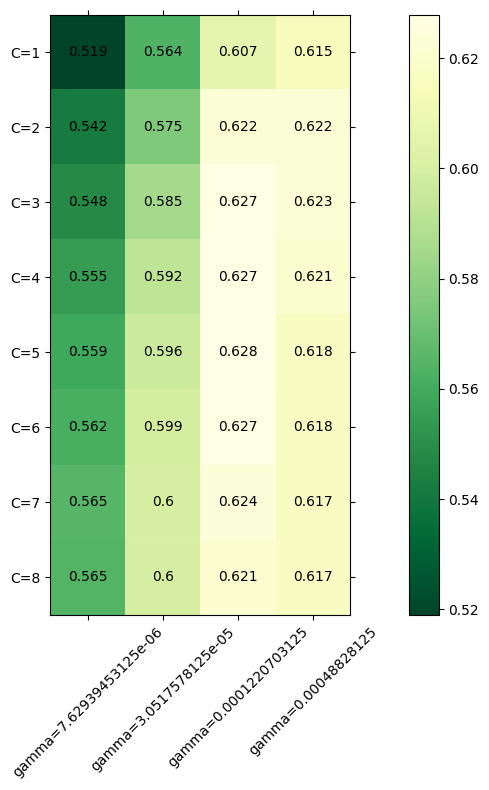

In [ ]:
from sklearn_evaluation import plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
plot.grid_search(grid.cv_results_, change=("gamma", "C"), cmap='YlGn_r', ax=ax)

Unfortunately, the refined grid search gives no extra improvement to the performance we found already with the first grid search. Before leaving this approach, we would like to mention that it would probably have a better chance, if we had tried to approximate PCA results with the whole train data. However, the accuracy is still far behind 70.56% we achieved with the autoencoder hidden representation. We remind that the latter representation uses 200 numbers, while the one we just tried 1'348, still with worse results!

## Approach 4: Implementing a Linear-kernel SVM

Having investigated all previous approaches using RBF-kernel SVMs, we now shift our attention towards other kernel functions. In this approach, we try to implement an SVM with a Linear kernel.

Based on our previous findings, we choose to use as input the hidden (encoded) representation of the autoencoder we trained in the very beginning, since it was the input representation that gave the best results by far.

For the Linear-kernel SVM, the only hyperparameter we need to define is the fault tolerance hyperparameter $C$. We perform, again, a grid search for the following values of $C$:

$C = 2^{-3}, 2^{-1}, \dots, 2^{11}$


In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel':['linear'],
              'C': [2 ** x for x in range(-3, 11, 2)],
              }

grid = GridSearchCV(SVC(), n_jobs=-1, verbose=3, param_grid=param_grid, cv=2)
grid.fit(X_train, y_train)
print(grid.best_params_)
clf = SVC(C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
clf.fit(X_train, y_train)
fit_evaluate_SVM(clf, X_train, y_train, X_test, y_test)

Best hyperparameters found: {'C': 0.5, 'kernel': 'linear'}
Accuracy score on train set        : 69.33874875302836 %.
Accuracy score on test set         : 65.33333333333333 %.
Time elapsed during fitting        : 36.36361598299845 sec
Number of support vectors per class: [1752  739 1765 1785 2110 1429]


Reaching a train accuracy of only 69.34% probably means that the train data is not linearly separable in their initial form/dimension. The mean accuracies for the different $C$ values tested in the grid search are shown in the following bar plot. We can see that the accuracy is about 63 to 65 % for all values. That could be a sign that our machine cannot solve the problem with a linear kernel. It would probably need a polynomial of higher degree, to, then, solve it linearly in Hilbert space.

<Axes: title={'center': 'Grid search results'}, xlabel='C', ylabel='Mean score'>

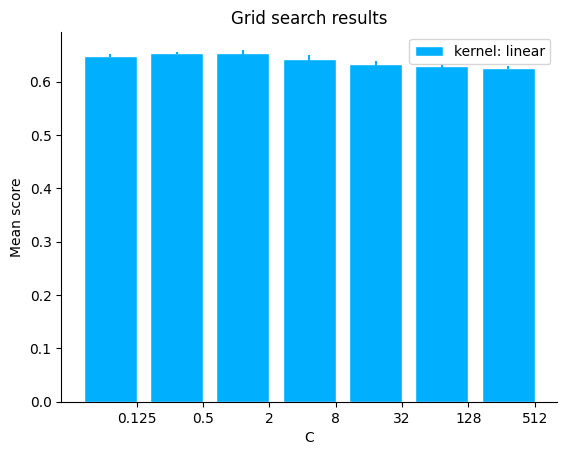

In [ ]:
from sklearn_evaluation import plot

plot.grid_search(grid.cv_results_, change=("C"), cmap='PuBu_r', kind="bar")

Fitting 2 folds for each of 17 candidates, totalling 34 fits
{'C': 0.6, 'kernel': 'linear'}
Accuracy score on train set        : 69.5382642154767 %.
Accuracy score on test set         : 65.46666666666667 %.
Number of support vectors per class: [1738  729 1759 1785 2101 1420]


<Axes: title={'center': 'Grid search results'}, xlabel='C', ylabel='Mean score'>

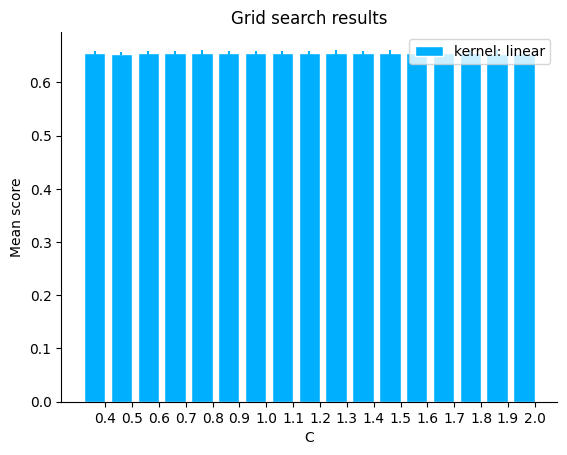

In [ ]:
# Refined grid search

param_grid = {'kernel':['linear'],
              'C': [float(x/10) for x in range(4, 21)] # [0.4, 0.5, ..., 2.0]
              }

grid = GridSearchCV(SVC(), n_jobs=-1, verbose=3, param_grid=param_grid, cv=2)
grid.fit(X_train, y_train)
print(grid.best_params_)
clf = SVC(C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
clf.fit(X_train, y_train)
print(f"Accuracy score on train set        : {clf.score(X_train, y_train) * 100} %.")
print(f"Accuracy score on test set         : {clf.score(X_test, y_test) * 100} %.")
print(f"Number of support vectors per class: {clf.n_support_}")

from sklearn_evaluation import plot

plot.grid_search(grid.cv_results_, change=("C"), cmap='PuBu_r', kind="bar")

The refined grid search that is presented above verifies our thought. The data still cannot be separated well by lines and that depicts in both train and test accuracy of the classifier.

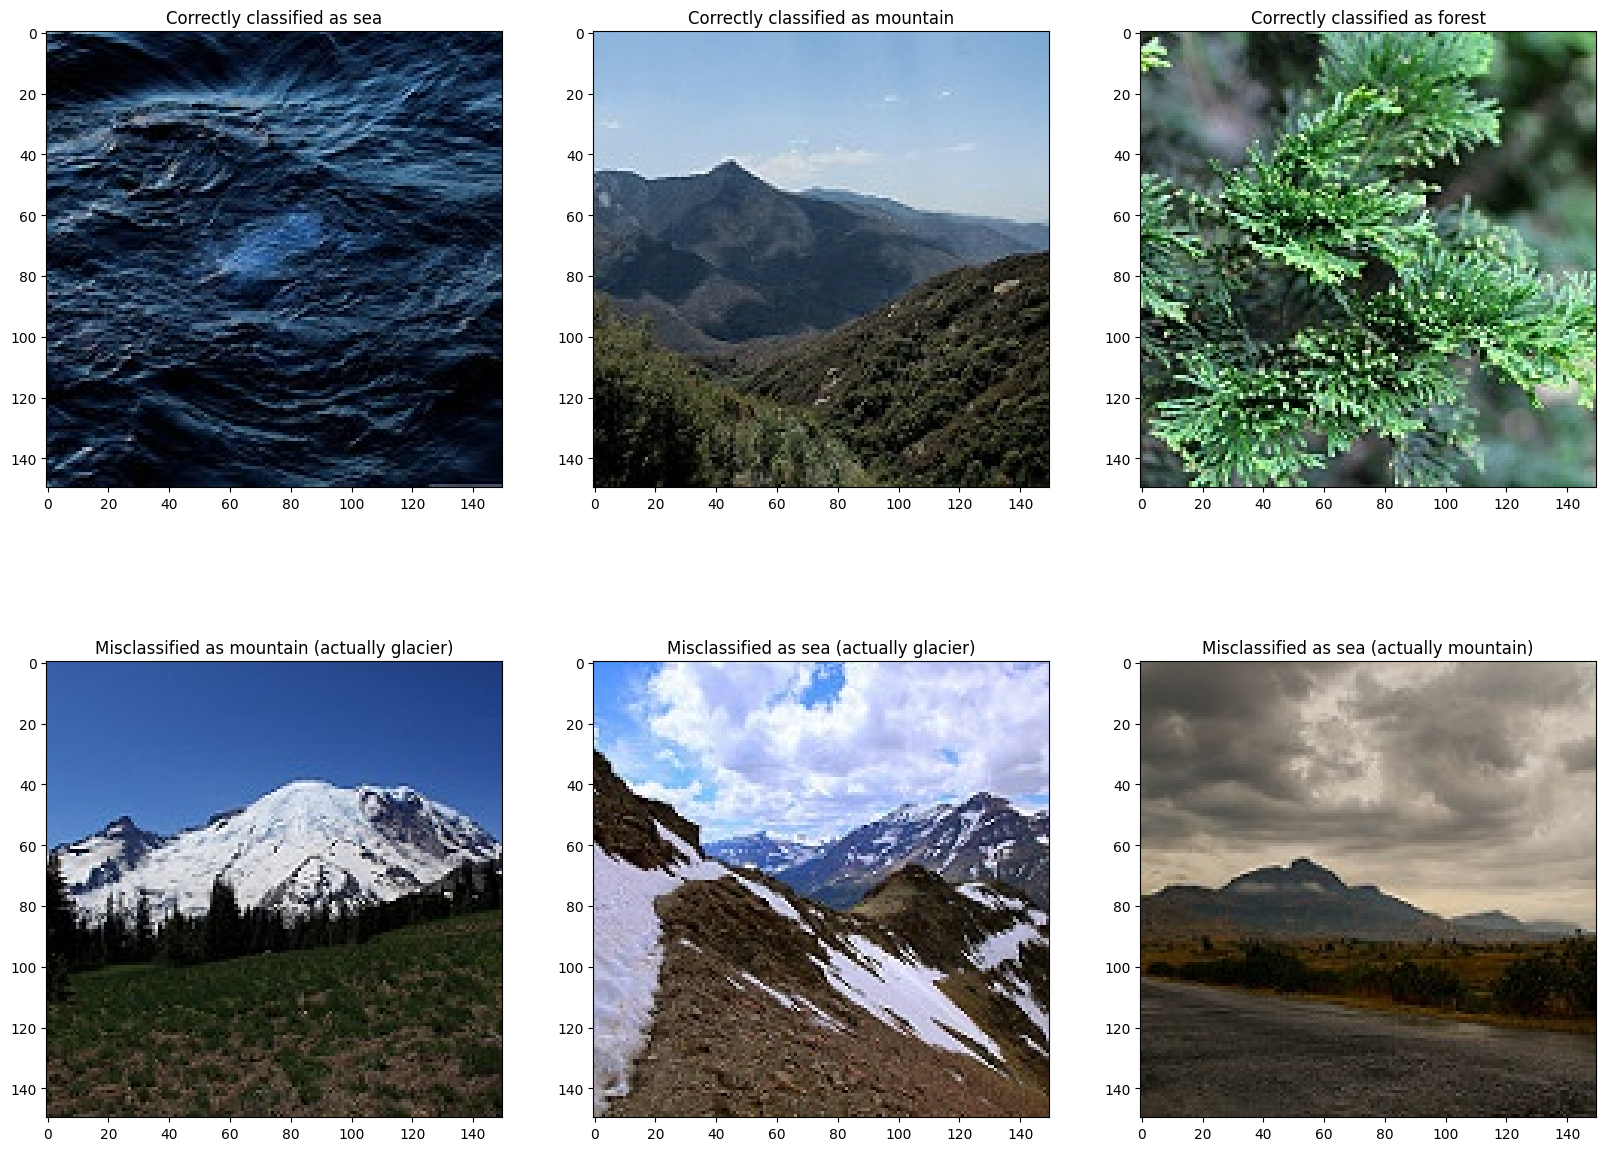

In [33]:
with open('/gdrive/My Drive/Kaggle/Dataset/test.npy', 'rb') as f:
  X_test_original = np.load(f)

plot_classification_examples(clf, X_test_original, X_test, y_test)

## Approach 5: Implementing a Polynomial-degree-2-kernel SVM

Guided by our findings, we now opt for implementing an SVM with polynomial kernel of degree 2. It is possible that, using a non-linear kernel, the data will be transformed to a better form, where straight lines wishfully can separate the classes among them. We adopt the same workflow: a general grid search, followed by a more specific one, based on the initial findings.

$C = 2^{-3}, 2^{-1}, \dots, 2^{11}$

$γ = 2^{-11}, 2^{-9}, \dots, 2^{3}$

Fitting 2 folds for each of 49 candidates, totalling 98 fits
{'C': 0.125, 'degree': 2, 'gamma': 0.5, 'kernel': 'poly'}
Accuracy score on train set        : 99.25894256804902 %.
Accuracy score on test set         : 66.8 %.
Number of support vectors per class: [1632  691 1619 1697 1713 1317]


<Axes: >

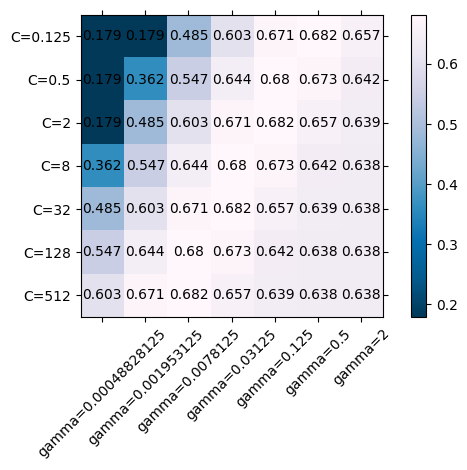

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel':['poly'],
              'C': [2 ** x for x in range(-3, 11, 2)],
              'gamma': [2 ** x for x in range(-11, 3, 2)],
              'degree': [2]
              }

grid = GridSearchCV(SVC(), n_jobs=-1, verbose=3, param_grid=param_grid, cv=2)
grid.fit(X_train, y_train)
print(grid.best_params_)
clf = SVC(gamma=grid.best_params_['gamma'], C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
clf.fit(X_train, y_train)
print(f"Accuracy score on train set        : {clf.score(X_train, y_train) * 100} %.")
print(f"Accuracy score on test set         : {clf.score(X_test, y_test) * 100} %.")
print(f"Number of support vectors per class: {clf.n_support_}")

from sklearn_evaluation import plot

plot.grid_search(grid.cv_results_, change=("C", "gamma"), cmap='PuBu_r')

The test accuracy remains almost the same. However, our assumption was true. The degree-2 polynomial kernel was powerfull enough to separate the train data (99.3% mean accuracy). In fact, the machine was too "powerfull" that it overfitted to the train data, failing to generalize on the test examples.

Fitting 2 folds for each of 42 candidates, totalling 84 fits
{'C': 0.00048828125, 'degree': 2, 'gamma': 8, 'kernel': 'poly'}
Accuracy score on train set        : 99.92874447769702 %.
Accuracy score on test set         : 65.93333333333334 %.
Number of support vectors per class: [1631  678 1595 1673 1679 1315]


<Axes: >

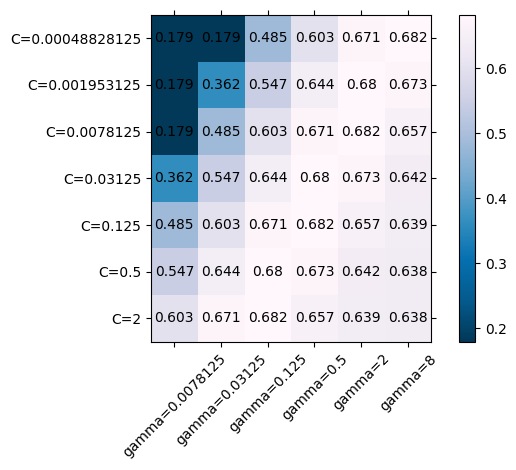

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel':['poly'],
              'C': [2 ** x for x in range(-11, 2, 2)],
              'gamma': [2 ** x for x in range(-7, 5, 2)],
              'degree': [2]
              }

grid = GridSearchCV(SVC(), n_jobs=-1, verbose=3, param_grid=param_grid, cv=2)
grid.fit(X_train, y_train)
print(grid.best_params_)
clf = SVC(gamma=grid.best_params_['gamma'], C=grid.best_params_['C'], kernel=grid.best_params_['kernel'], degree=grid.best_params_['degree'])
clf.fit(X_train, y_train)
print(f"Accuracy score on train set        : {clf.score(X_train, y_train) * 100} %.")
print(f"Accuracy score on test set         : {clf.score(X_test, y_test) * 100} %.")
print(f"Number of support vectors per class: {clf.n_support_}")

from sklearn_evaluation import plot

plot.grid_search(grid.cv_results_, change=("C", "gamma"), cmap='PuBu_r')

The refined grid search on a more specific area of the hyperparameter space verifies the overfitting behavior of the machine. The train accuracy remains extremelly high, while the test accuracy really low.

## Final Approach (approach 6): Grid search in polynomial-kernel SVMs space

Having tried all the above, we opt for a final attempt: a BIG grid search trying to define a good polynomial-kernel SVM. This time the grid search has three parameters: $C$, $\gamma$ and degree of the kernel function. The examined combinations are generated by the following values for the hyperparameters:


$C = 2^{-3}, 2^{-1}, \dots, 2^{11}$

$γ = 2^{-11}, 2^{-9}, \dots, 2^{3}$

$degree = \{2, 3, 4, 5, 6\}$

{'C': 0.00048828125, 'degree': 4, 'gamma': 0.25, 'kernel': 'poly'}
Accuracy score on train set        : 81.04603106740772 %.
Accuracy score on test set         : 69.36666666666666 %.
Time elapsed during fitting        : 29.05086519500037 sec
Number of support vectors per class: [1623  641 1685 1681 1907 1303]


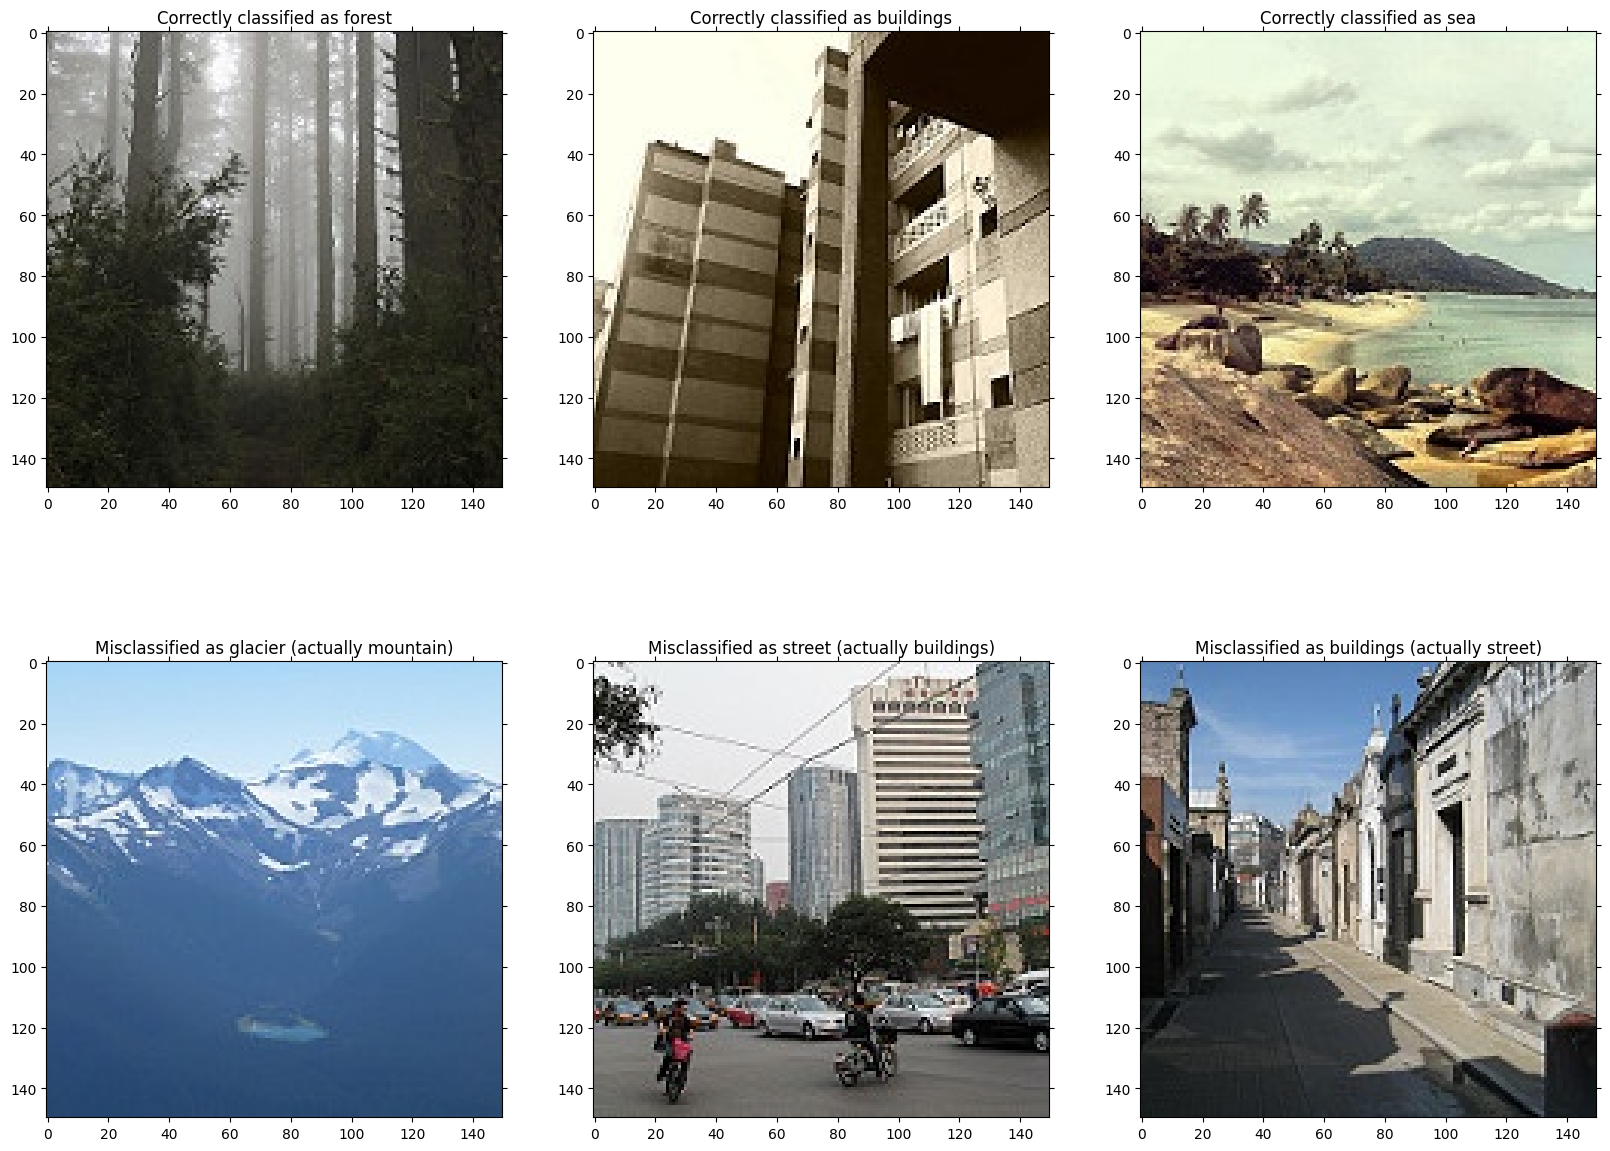

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel':['poly'],
              'C': [2 ** x for x in range(-11, 3, 2)],
              'gamma': [2 ** x for x in range(-5, 2)],
              'degree': [2, 3, 4, 5, 6]
              }

grid = GridSearchCV(SVC(), n_jobs=-1, verbose=3, param_grid=param_grid, cv=2)
grid.fit(X_train, y_train)
print(grid.best_params_)
clf = SVC(gamma=grid.best_params_['gamma'], C=grid.best_params_['C'], kernel=grid.best_params_['kernel'], degree=grid.best_params_['degree'])
fit_evaluate_SVM(clf, X_train, y_train, X_test, y_test)
plot_classification_examples(clf, X_test, y_test)

# Comparison with KNN and NC classifiers

Up to that point, we have thoroughly covered multiple SVM flavor implementations. The best test accuracy we managed to achieve is 70.56 for an RBF-kernel SVM with $C = 5$ and $\gamma = 0.125$, trained on the hidden representation (200 numbers) we obtained from the encoder we extracted from our trained autoencoder.

We compare the accuracy of our Network with the accuracy that a K-Nearest-Neighbors and a Nearest Centroid classifier can achieve on the same data.

In [18]:
import numpy as np
from sklearn.utils import shuffle

nof_samples = 14034


with open('/gdrive/My Drive/Kaggle/X_train_transformed.npy', 'rb') as f:
  X_train = np.load(f)

with open('/gdrive/My Drive/Kaggle/Dataset/train labels.npy', 'rb') as f:
  y_train = np.load(f)

X_train, y_train = shuffle(X_train, y_train, random_state=7)
# X_train = X_train[:nof_samples]
# y_train = y_train[:nof_samples]

print(f"Shape of X_train{X_train.shape}")
print(f"Shape of y_train{y_train.shape}")

with open('/gdrive/My Drive/Kaggle/X_test_transformed.npy', 'rb') as f:
  X_test = np.load(f)

with open('/gdrive/My Drive/Kaggle/Dataset/test labels.npy', 'rb') as f:
  y_test = np.load(f)


print(f"Shape of X_test{X_test.shape}")
print(f"Shape of y_test{y_test.shape}")

Shape of X_train(14034, 200)
Shape of y_train(14034,)
Shape of X_test(3000, 200)
Shape of y_test(3000,)


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from timeit import default_timer as timer

knn_classifier1 = KNeighborsClassifier(n_neighbors=1)
knn_classifier1.fit(X_train, y_train)
print('_________________________________KNN1_________________________________')
print(f"Accuracy score on train set: {knn_classifier1.score(X_train, y_train) * 100} %.")
print(f"Accuracy score on test  set: {knn_classifier1.score(X_test, y_test) * 100} %.")
print()

knn_classifier3 = KNeighborsClassifier(n_neighbors=3)
knn_classifier3.fit(X_train, y_train)
print('_________________________________KNN3_________________________________')
print(f"Accuracy score on train set: {knn_classifier3.score(X_train, y_train) * 100} %.")
print(f"Accuracy score on test  set: {knn_classifier3.score(X_test, y_test) * 100} %.")
print()

nc_classifier = NearestCentroid()
nc_classifier.fit(X_train, y_train)
print('__________________________________NC__________________________________')
print(f"Accuracy score on train set: {nc_classifier.score(X_train, y_train) * 100} %.")
print(f"Accuracy score on test  set: {nc_classifier.score(X_test, y_test) * 100} %.")
print()

svm_classifier = SVC(gamma=0.125, C=5, kernel='rbf')
svm_classifier.fit(X_train, y_train)
print('_________________________________SVM__________________________________')
print(f"Accuracy score on train set: {svm_classifier.score(X_train, y_train) * 100} %.")
print(f"Accuracy score on test  set: {svm_classifier.score(X_test, y_test) * 100} %.")
print()

_________________________________KNN1_________________________________
Accuracy score on train set: 99.92874447769702 %.
Accuracy score on test  set: 52.300000000000004 %.

_________________________________KNN3_________________________________
Accuracy score on train set: 75.83725238705999 %.
Accuracy score on test  set: 56.333333333333336 %.

__________________________________NC__________________________________
Accuracy score on train set: 47.18540686903235 %.
Accuracy score on test  set: 46.833333333333336 %.

_________________________________SVM__________________________________
Accuracy score on train set: 86.88898389625196 %.
Accuracy score on test  set: 70.56666666666666 %.



We observe that the SVM classifier outperforms all other (KNN1, KNN3, NC) classifiers by far. The latter finding summarizes the pros and cons of the Support Vector Machine classifiers: they can be really powerfull machines, with an easy inclination to overfitting, while finding the best hyperparameters can be really complex, depending on the kernel type one chooses.